In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import src
import matplotlib.pyplot as plt
import numpy as np
from glob import glob

## Prepare data

Read power spectrum and bispectrum (BAO and noBAO)

In [4]:
prepar = src.io.Preparer()

loading cache...
(15000, 30)
loading cache...
(15000, 2600)
Done reading Molino


In [6]:
prepar.prep('glam', 'gal')

creating cache with iy=1
(1097, 30)
creating cache with iy=1
(935, 30)
creating cache with iy=3
(1097, 2600)
creating cache with iy=3
(970, 2600)
Done writing mean and covariances for mock=glam and gal=gal


In [7]:
prepar.prep('abacus', 'lrg')

creating cache with iy=1
(25, 30)
creating cache with iy=2
(25, 30)
creating cache with iy=3
(25, 2600)
creating cache with iy=4
(25, 2600)
Done writing mean and covariances for mock=abacus and gal=lrg


## Plot data

In [8]:
pk_glam = src.io.Spectrum('./cache/glam_gal_pkmean.npz')
pks_glam = src.io.Spectrum('./cache/glam_gal_pksmoothmean.npz')
pk_abacus = src.io.Spectrum('./cache/abacus_lrg_pkmean.npz')
pks_abacus = src.io.Spectrum('./cache/abacus_lrg_pksmoothmean.npz')

bk_glam = src.io.Spectrum('./cache/glam_gal_bkmean.npz')
bks_glam = src.io.Spectrum('./cache/glam_gal_bksmoothmean.npz')
bk_abacus = src.io.Spectrum('./cache/abacus_lrg_bkmean.npz')
bks_abacus = src.io.Spectrum('./cache/abacus_lrg_bksmoothmean.npz')

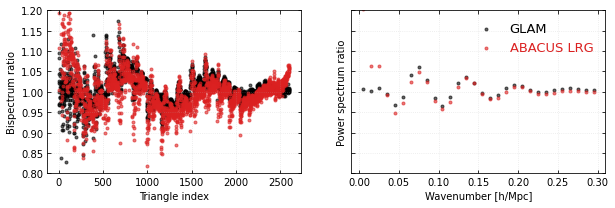

In [9]:
tix =  np.arange(bk_glam.x.shape[0])
src.plots.plot_spectra([(tix,   bk_glam.y/bks_glam.y),
                        (tix,   bk_abacus.y/bks_abacus.y)], 
                       [(pk_glam.x, pk_glam.y/pks_glam.y),
                        (pk_glam.x, pk_abacus.y/pks_abacus.y)],
                       ['GLAM', 'ABACUS LRG'])

In [26]:
bk_abacus = src.io.Spectrum('./cache/abacus_lrg_bkmean.npz')
bk_abacus_old = src.io.Spectrum('./cache27feb/bk_mean_abacus_bao.npz')

Text(0, 0.5, 'k1*k2*k3*B')

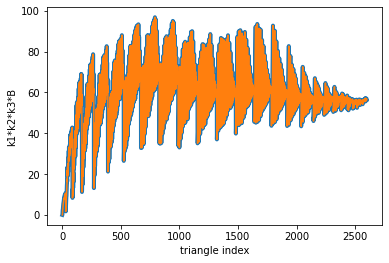

In [39]:
plt.plot(bk_abacus.x[:, 0]*bk_abacus.x[:, 1]*bk_abacus.x[:, 2]*bk_abacus.y, lw=4)
plt.plot(bk_abacus.x[:, 0]*bk_abacus.x[:, 1]*bk_abacus.x[:, 2]*bk_abacus_old.y)
plt.xlabel('triangle index')
plt.ylabel('k1*k2*k3*B')

## Test MCMC

0.03
0.03
0.03
0.03
0.03
0.03


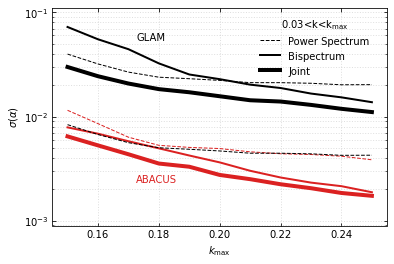

In [18]:
def plot_sigmakmax():
    
    kmax1, sigma1 = src.io.read_sigmas(glob('mcmc_feb27/pk_abacus_lrg_abacus_*.npz'))
    kmax2, sigma2 = src.io.read_sigmas(glob('mcmc_feb27/pk_glam_gal_glam_*.npz'))
    kmax3, sigma3 = src.io.read_sigmas(glob('mcmc_jan31/bk_abacus_abacus_*.npz'))
    kmax4, sigma4 = src.io.read_sigmas(glob('mcmc_jan31/bk_glam_glam_*.npz'))
    kmax5, sigma5 = src.io.read_sigmas(glob('mcmc_jan31/pb_abacus_abacus_*.npz'))
    kmax6, sigma6 = src.io.read_sigmas(glob('mcmc_jan31/pb_glam_glam_*.npz'))
    
    fg, ax = plt.subplots()
    
    ax.plot(kmax2, sigma2, color='#000000', lw=1, label='Power Spectrum', ls='--')
    ax.plot(kmax4, sigma4, color='#000000', lw=2, label='Bispectrum')
    ax.plot(kmax6, sigma6, color='#000000', lw=4, label='Joint')

    ax.plot(kmax1, sigma1, color='#db2121', lw=1, ls='--')
    ax.plot(kmax3, sigma3, color='#db2121', lw=2)
    ax.plot(kmax5, sigma5, color='#db2121', lw=4)
    ax.plot(kmax2, sigma2/np.sqrt(8**1.5), color='#000000', lw=1, ls='--')

    lgn = fg.legend(title=r'0.03<k<k$_{\rm max}$', bbox_to_anchor=(0.88, 0.88), frameon=False)        
    ax.set(xlabel=r'$k_{\rm max}$', ylabel=r'$\sigma (\alpha)$', yscale='log', ylim=(9.0e-4, 1.1e-1))
    ax.tick_params(direction='in', right=True, top=True, which='both', axis='both')
    ax.grid(True, ls=':', lw=1, which='both', alpha=0.4)    
    ax.text(0.25, 0.85, 'GLAM', transform=ax.transAxes)
    ax.text(0.25, 0.2, 'ABACUS', color='#db2121', transform=ax.transAxes)    
    fg.savefig('../bisp4desi/figures/sigma_kmax.pdf', bbox_inches='tight')   
    
plot_sigmakmax()

In [9]:
chi2s = {}
for s in ['glam', 'abacus']:
    for p in ['pk', 'bk']:
        chi2s[f'{s}_{p}'] = read_chi2list(np.sort(glob(f'mcmc_jan31/{p}_{s}_{s}_*.npz')))

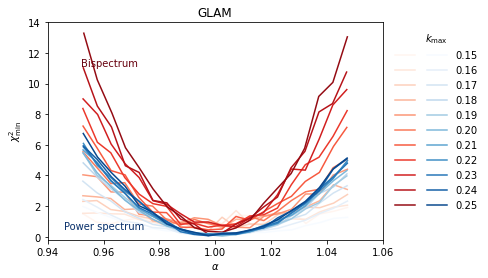

In [10]:
src.plots.plot_chi2(chi2s['glam_bk'], chi2s['glam_pk'], title='GLAM')

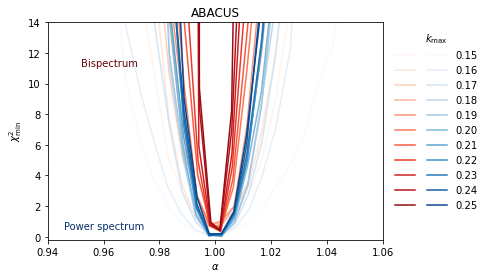

In [11]:
src.plots.plot_chi2(chi2s['abacus_bk'], chi2s['abacus_pk'], title='ABACUS')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

In [82]:
def plot_detection(s, km='0.250'):    
    d1 = np.load(f'mcmc_jan31/pk_{s}_{s}_0.030_{km}.npz')
    d2 = np.load(f'mcmc_jan31/bk_{s}_{s}_0.030_{km}.npz')
    d3 = np.load(f'mcmc_jan31/pb_{s}_{s}_0.030_{km}.npz')

    fig, ax = plt.subplots()
    alpha_edge = np.linspace(0.95, 1.05, num=21)

    ls = ['--', '-', '-']
    lw = [1, 2, 4]

    for i, (di, ni) in enumerate(zip([d1, d2, d3],
                                     ['Power Spectrum', 'Bispectrum', 'Joint'])):
        x = di['chain'][5000:, :, 0].flatten()
        y = -2.*di['log_prob'][5000:, :].flatten()
        print(y.min())
        ym = binned_statistic(x, y, statistic=np.min, bins=alpha_edge)[0]
        xm = binned_statistic(x, x, statistic=np.mean, bins=alpha_edge)[0]
        ax.plot(xm, ym, label=ni, ls=ls[i], color='#000000', alpha=0.8, lw=lw[i])
        
    leg = ax.legend(frameon=False, title=fr'$0.03<k<{km}$')
    ax.set(xlabel=r'$\alpha$', ylabel=r'$\chi^{2}_{\rm min}$', title=s.upper(), 
           ylim=(-0.2, 14), xlim=(0.94, 1.06))
    fig.savefig(f'../bisp4desi/figures/chi2alpha_{s}.pdf', bbox_inches='tight')

0.177504177320562
0.7644025550586349
1.2842154629033131


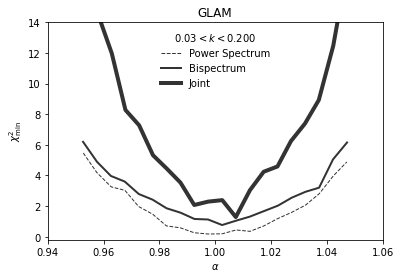

In [88]:
plot_detection('glam', '0.200')

0.12390150304562333
0.8977478643033432
2.545098892381207


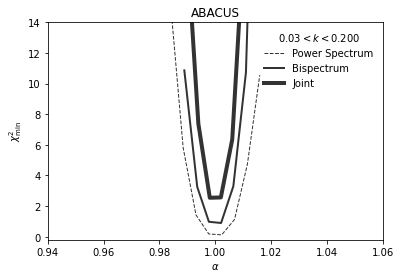

In [89]:
plot_detection('abacus', '0.200')

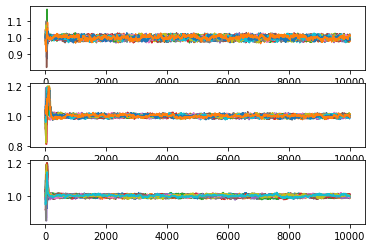

In [62]:
s = 'abacus'
km = '0.160'
d1 = np.load(f'mcmc_jan31/pk_{s}_{s}_0.030_{km}.npz')
d2 = np.load(f'mcmc_jan31/bk_{s}_{s}_0.030_{km}.npz')
d3 = np.load(f'mcmc_jan31/pb_{s}_{s}_0.030_{km}.npz')

fg, ax = plt.subplots(nrows=3)
for i, di in enumerate([d1, d2, d3]):    
    ax[i].plot(di['chain'][:, :, 0])



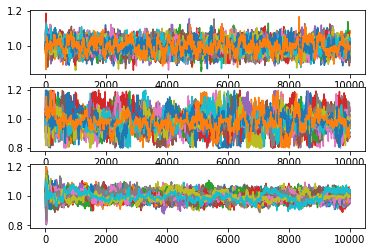

In [51]:
s = 'glam'
km = '0.160'
d1 = np.load(f'mcmc_jan31/pk_{s}_{s}_0.030_{km}.npz')
d2 = np.load(f'mcmc_jan31/bk_{s}_{s}_0.030_{km}.npz')
d3 = np.load(f'mcmc_jan31/pb_{s}_{s}_0.030_{km}.npz')

fg, ax = plt.subplots(nrows=3)
for i, di in enumerate([d1, d2, d3]):    
    ax[i].plot(di['chain'][:, :, 0])


In [3]:
dl = DataLoader()

In [4]:
k, pk_glam = dl.load('glam_pk_bao', 1)
__, pk_glam_nobao = dl.load('glam_pk_nobao', 1)
__, pk_molino = dl.load('molino_pk', 1)

k3, bk_glam = dl.load('glam_bk_bao', 3)
__, bk_glam_nobao = dl.load('glam_bk_nobao', 3)
__, bk_molino = dl.load('molino_bk', 3)

loading cache...
(1097, 30)
loading cache...
(935, 30)
loading cache...
(15000, 30)
loading cache...
(1097, 2600)
loading cache...
(970, 2600)
loading cache...
(15000, 2600)


In [11]:
c_g = np.column_stack([pk_glam/pk_glam_nobao.mean(axis=0), bk_glam/bk_glam_nobao.mean(axis=0)])
c_m = np.column_stack([pk_molino, bk_molino])
c_g.shape, c_m.shape

((1097, 2630), (15000, 2630))

In [36]:
class A(object):
    def __init__(self, v):
        self.a = v
    def __call__(self, x):
        return self.a+x
    
class B(object):
    def __init__(self, v):
        self.a = v
    def __call__(self, x):
        return self.a-x 
    
    
class D(A, B):
    def __init__(self, v1, v2):
        A.__init__(self, v1)
        B.__init__(self, v2)
    
    def __call__(self, x1, x2):
        c1 = A.__call__(self, x1)
        c2 = B.__call__(self, x2)
        return (c1, c2)

In [37]:
a = A(12)
b = B(12)

In [38]:
d = D(12, 12)

In [39]:
d(2, 3)

(14, 9)

In [40]:
a(2), b(3)

(14, 9)

(0.8, 1.2)

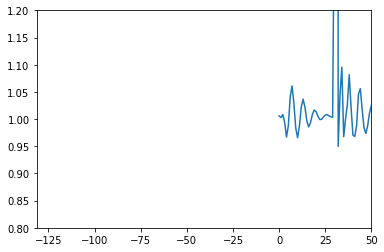

In [10]:
plt.plot(c.mean(axis=0))
plt.xlim(xmax=50)
plt.ylim(0.8, 1.2)

In [27]:
def gelman_rubin(chain):
    # chain: #steps, #chain
    ssq = np.var(chain, axis=0, ddof=1) 
    W = np.mean(ssq, axis=0)   # within chain var
    pb = np.mean(chain, axis=0)
    pbb = np.mean(pb, axis=0)

    n = chain.shape[0]
    m = chain.shape[1]    
    B = n / (m - 1) * np.sum((pbb - pb)**2, axis=0) # between chain var
    var_p = (n - 1) / n * W + 1 / n * B
    rhat = np.sqrt(var_p / W)
    return rhat

In [30]:
gelman_rubin(d_['chain'][:1000, :, 0])

1.0088613431756197

In [25]:
d_['chain'][5000:, :, 0].shape

(5000, 22)

[0.96224234 1.06423153]
[0.69675414 1.54220246]
[-6.0835285   4.74141155]
[-40.67944398  47.81204999]
[-0.23482382  0.26914284]
[-142.23198506  120.46243245]
[-0.0044365   0.00392685]


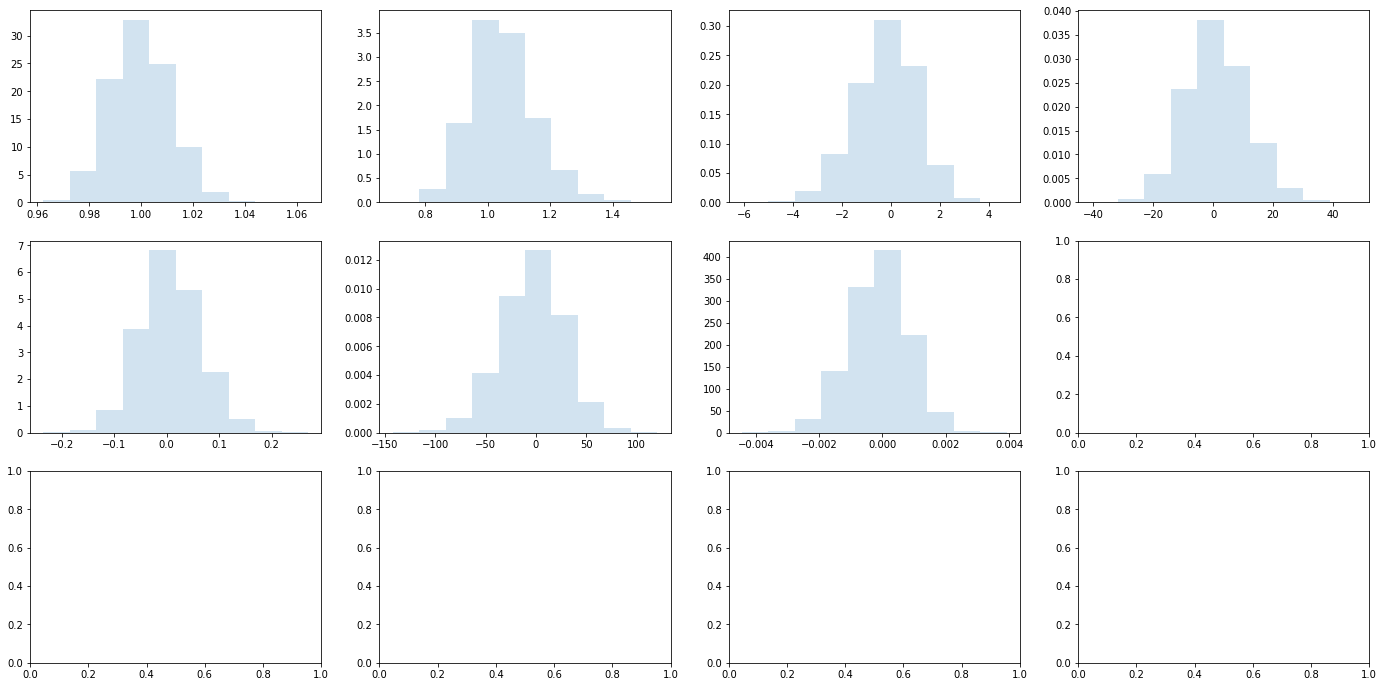

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(24, 12))
ax = ax.flatten()

for i in range(d_['chain'].shape[-1]):
    # ax[i].hist(d['chain'][5000:, :, i].flatten(), alpha=0.2, density=True)
    ax[i].hist(d_['chain'][5000:, :, i].flatten(), alpha=0.2, density=True)
    print(np.percentile(d_['chain'][5000:, :, i].flatten(), [0, 100]))
    

Text(0.5, 0, 'wavenumber [h/Mpc]')

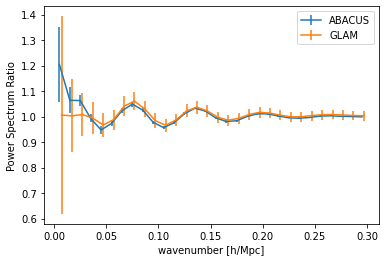

In [18]:
i = 0
for mock in ['abacus', 'glam']:
    
    stat = 'pk'
    # mock = 'abacus'
    temp = mock
    y = Spectrum(f'cache/{stat}_mean_{mock}_bao.npz')
    ys = Spectrum(f'cache/{stat}_mean_{temp}_nobao.npz')
    cov = Spectrum(f'cache/{stat}_cov_{mock}_bao.npz')
    plt.errorbar(y.x+0.002*i, y.y/ys.y, yerr=np.diagonal(cov.y)**0.5, label=mock.upper())
    i += 1
plt.legend()
plt.ylabel('Power Spectrum Ratio')
plt.xlabel('wavenumber [h/Mpc]')

In [17]:
y.x

array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
       0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265,
       0.275, 0.285, 0.295])

In [5]:
is_g = (y.x > 0.015) & (y.x < 0.13) 
is_g = is_g.sum(axis=1) == 3

x_g = y.x[is_g]
r_g = (y.y/ys.y)[is_g]
c_g = cov.y[is_g,:,][:, is_g]
ic_g = np.linalg.inv(c_g)

In [9]:
from src.models import BiSpectrum

In [10]:
r_int = BiSpectrum(y.x, y.y/ys.y)

In [29]:
def loglike(p):
    res = r_g - r_int(x_g, p)
    is_ok = ~np.isnan(res)    
    #if is_ok.sum() ==0:
    #    return -np.inf
    #else:            
    return  -0.5*res[is_ok].dot(ic_g[is_ok, :][:, is_ok].dot(res[is_ok]))

def logprior(p):
    lp = 0.
    lp += 0. if  0.9 < p[0] < 1.1 else -np.inf
    lp += 0. if  0.8 < p[1] < 1.2 else -np.inf    
    for p_i in p[2:]:
        lp += 0. if  -1 < p_i < 1. else -np.inf
    return lp

def logpost(p):
    return loglike(p) + logprior(p)

def nlogpost(p):
    return -1.*logpost(p)

In [30]:
guess = np.array([1.001, 1.001, 1.1e-5, 1.2e-5, 1.3e-5, 1.1e-5, 1.2e-5, 1.3e-5, 1.0e-5, 0.9e-5, 1.1e-5])
start = (guess + guess*0.02*np.random.randn(50, 11))

In [31]:
for s in start:
    print(logpost(s))

-0.019408861842226496
-0.007620845077150634
-0.007888390203940148
-0.008862727394702438
-0.0024373891472734568
-0.01406453427391325
-0.017468073171336744
-0.0901179160143377
-0.0023148334411223475
-0.020863976518058932
-0.034029590589402275
-0.008627994620870622
-0.002027414006793732
-0.007155820757474676
-0.005916715661599145
-0.0031888498545395083
-0.026194485193954536
-0.009948746348104914
-0.004950925198240695
-0.0030730159466689374
-0.002608491247113996
-0.013832275991846894
-0.01014591490436914
-0.017581117210251573
-0.018327415319419213
-0.00800648592484167
-0.009829408943324135
-0.03152695528977704
-0.06331713761471565
-0.013110156783927913
-0.01415095152754359
-0.01224262929471479
-0.010791320474832326
-0.054848706455694604
-0.021607669673610247
-0.013293553227040206
-0.003061372293617159
-0.0006656195760880825
-0.001774707942634408
-0.018009694934513945
-0.009454128082254858
-0.010761348131810008
-0.10845174738823338
-0.030046678096103747
-0.0014945713867181255
-0.00276594295

In [ ]:
#     vr = 8
#     p = 1.5
#     ax[2].plot(bk_abacus.var(axis=0)/p3_abacus*vr**p, label='ABACUS', alpha=0.8)
#     ax[2].plot(bk_glam.var(axis=0)/p3_glam,           label='GLAM')
#     ax[2].plot(bk_molino.var(axis=0)/p3_molino,       label='MOLINO')
#     ax[3].plot(k, pk_abacus.var(axis=0)/pk_abacus.mean(axis=0)**2*vr**p, label='ABACUS')
#     ax[3].plot(k, pk_glam.var(axis=0)/pk_glam.mean(axis=0)**2,           label='GLAM')
#     ax[3].plot(k, pk_molino.var(axis=0)/pk_molino.mean(axis=0)**2,       label='MOLINO')
#     ax[2].set(xlabel='Triangle index', yscale='log', 
#               ylabel='Normalized bispectrum dispersion')#, ylabel=r'$\frac{\sigma^{2}_{B}}{P^{3}V^{1.5}}$')
#     ax[3].legend(bbox_to_anchor=(-1, 2.1, 1.5, 0.15), 
#                  mode='expand', ncol=3, frameon=False, fontsize=13)    
#     # fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
#     # ax[0].set(ylabel=r'$\chi^{2}(\alpha)$', xlabel=r'$\alpha$', title='Scoccimaro template')
#     # ax[1].set(xlabel=r'$\alpha$', title='GLAM template')
#     # # different curves for different k-max values

#     # fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
    # ax[0].set(xlabel='Triangle index', title='GLAM', ylabel='Bispectrum ratio')
    # ax[1].set(xlabel=r'kmax', title='GLAM', ylabel=r'$\sigma(\alpha)$')      

In [11]:
pk_glam_bao.x, pk_glam_bao.y

(array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
        0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
        0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265,
        0.275, 0.285, 0.295]),
 array([13.30533495, 12.26090917,  9.8172015 ,  7.718056  ,  6.04934489,
         5.11676342,  4.53520081,  3.95469598,  3.29829311,  2.75108726,
         2.37053697,  2.14782723,  1.98742684,  1.81072653,  1.61351515,
         1.43488749,  1.29848154,  1.20190007,  1.12622522,  1.052373  ,
         0.97680565,  0.90427197,  0.84115018,  0.78982083,  0.74668514,
         0.70710681,  0.66898349,  0.63290016,  0.59951996,  0.56984191]))

array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
       0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265,
       0.275, 0.285, 0.295])

In [ ]:
k, pk_glam = dl.load('glam_pk_bao', 1)
__, pk_glam_nobao = dl.load('glam_pk_nobao', 1)
__, pk_molino = dl.load('molino_pk', 1)
__, pk_abacus = dl.load('abacus_pk', 1)
__, pk_abacus_nobao = dl.load('abacus_pk_nobao', 2)

k3, bk_glam = dl.load('glam_bk_bao', 3)
__, bk_glam_nobao = dl.load('glam_bk_nobao', 3)
__, bk_molino = dl.load('molino_bk', 3)
__, bk_abacus = dl.load('abacus_bk', 3)
__, bk_abacus_nobao = dl.load('abacus_bk_nobao', 4)

p3_abacus = get_p3(k3, pk_abacus.mean(axis=0))
p3_molino = get_p3(k3, pk_molino.mean(axis=0))
p3_glam   = get_p3(k3, pk_glam.mean(axis=0))



loading cache...
(1097, 30)
loading cache...
(935, 30)
loading cache...
(15000, 30)
loading cache...
(25, 30)
loading cache...
(25, 30)
loading cache...
(1097, 2600)
loading cache...
(970, 2600)
loading cache...
(15000, 2600)
loading cache...
(25, 2600)
loading cache...
(25, 2600)


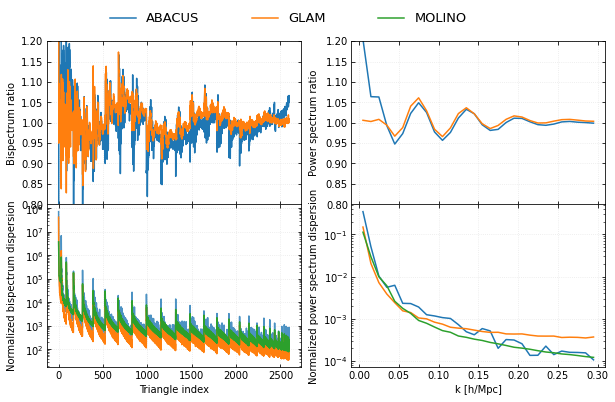

In [5]:
plot_spectra(dl)

loading cache...
(1097, 30)
loading cache...
(935, 30)
loading cache...
(15000, 30)
loading cache...
(25, 30)
loading cache...
(25, 30)
loading cache...
(1097, 2600)
loading cache...
(970, 2600)
loading cache...
(15000, 2600)
loading cache...
(25, 2600)
loading cache...
(25, 2600)


In [7]:
# C_P ~ var(P)/(P^{2}V^p)  # p = 1.5
# C_B ~ var(B)/(P^{3}V^p)

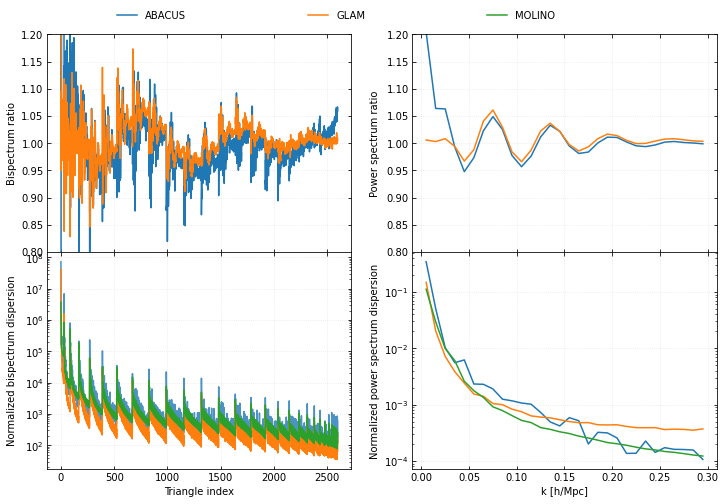

In [8]:
rcov_p = get_cov(pk_molino)
rcov_b = get_cov(bk_molino)

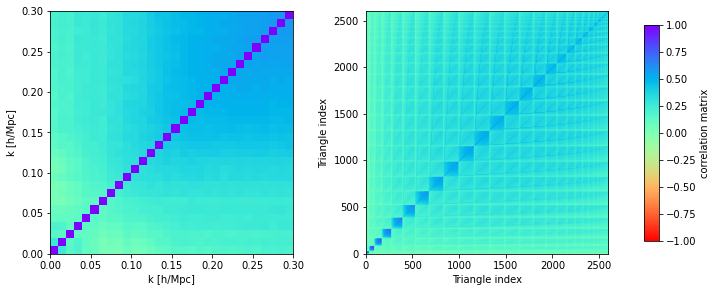

In [10]:
plot_rcov(rcov_p, rcov_b)

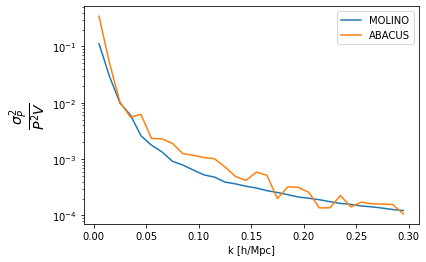

In [2]:
%matplotlib inline

In [3]:
import helpers as hp

In [5]:
bk_a = hp.read_abacus_bk()
bk_g = hp.read_glam_bk()
bk_gs = hp.read_glam_bk_nobao()

In [21]:
files = glob('/mnt/data1/Abacus_All/all_pk_LRGz0_8000.txtall_bk_LRGz0_*.txt')
# d = np.loadtxt('/mnt/data1/Abacus_All/all_bispectrum/all_bk_LRGz0_8000.txt').T
# d.shape
print(len(files))
y_1 = []
for file_i in files:
    d_ = np.loadtxt(file_i).T
    y_1.append(d_[4, :])
bk_as = np.mean(y_1, axis=0)

25


In [27]:
bk_g['pk'].shape

(1097, 2600)

In [15]:
bk_a['pk'].shape

(25, 2600, 3)

Text(0, 0.5, 'Bispectrum Ratio')

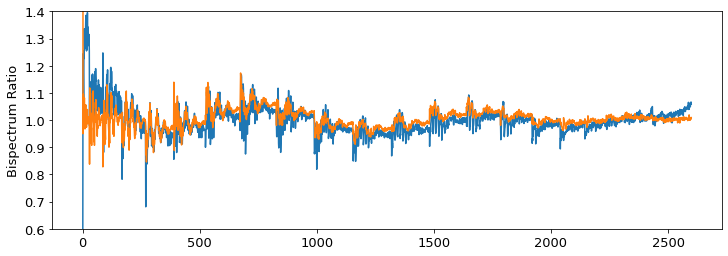

In [30]:
plt.figure(figsize=(12, 4))
plt.plot(bk_a['pk'][:, :, 0].mean(axis=0)/bk_as)
plt.plot(bk_g['pk'].mean(axis=0)/bk_gs['pk'].mean(axis=0))
plt.ylim(0.6, 1.4)
plt.ylabel('Bispectrum Ratio')

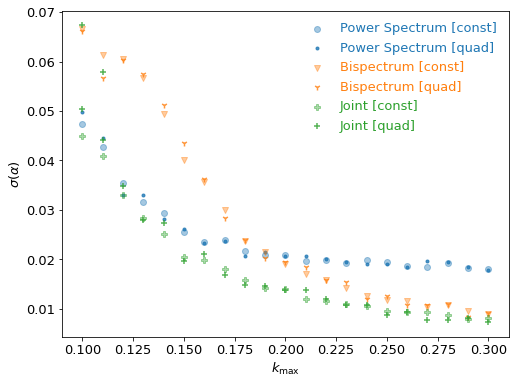

In [3]:
plot_sigma_kmax()

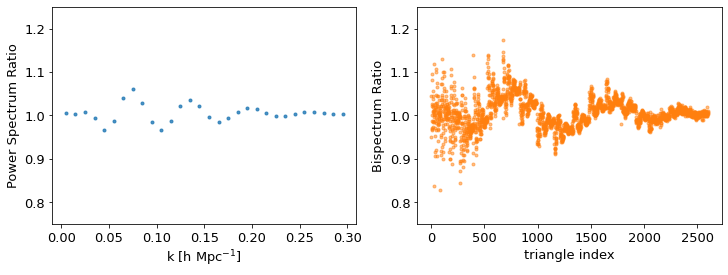

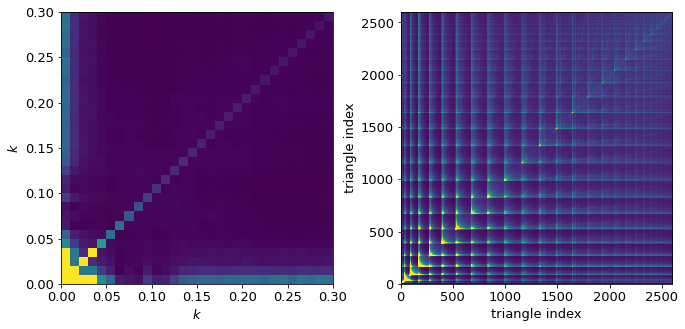

In [4]:
plot_spectra_glam()

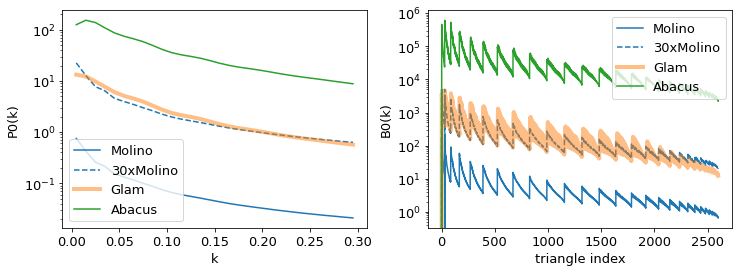

In [5]:
plot_spectra()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


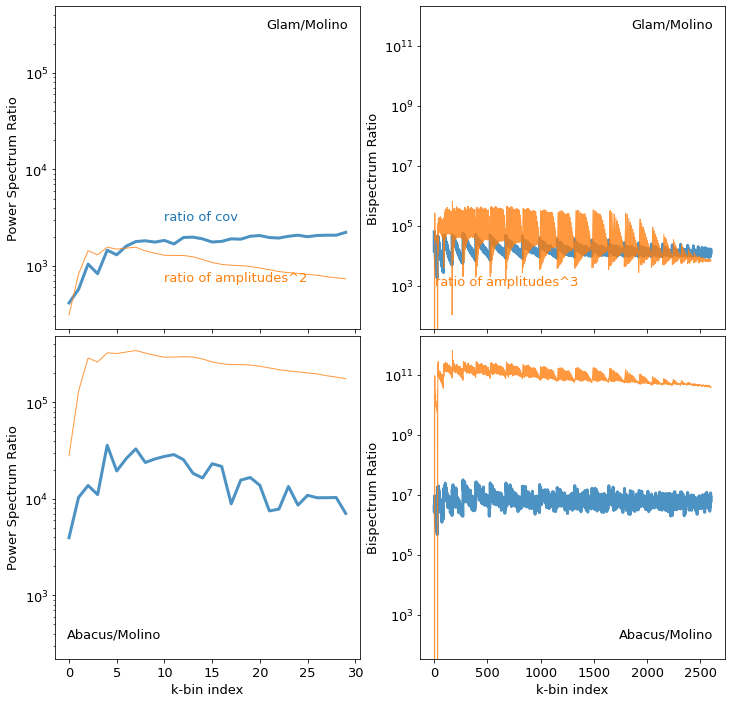

In [13]:
plot_ratios()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


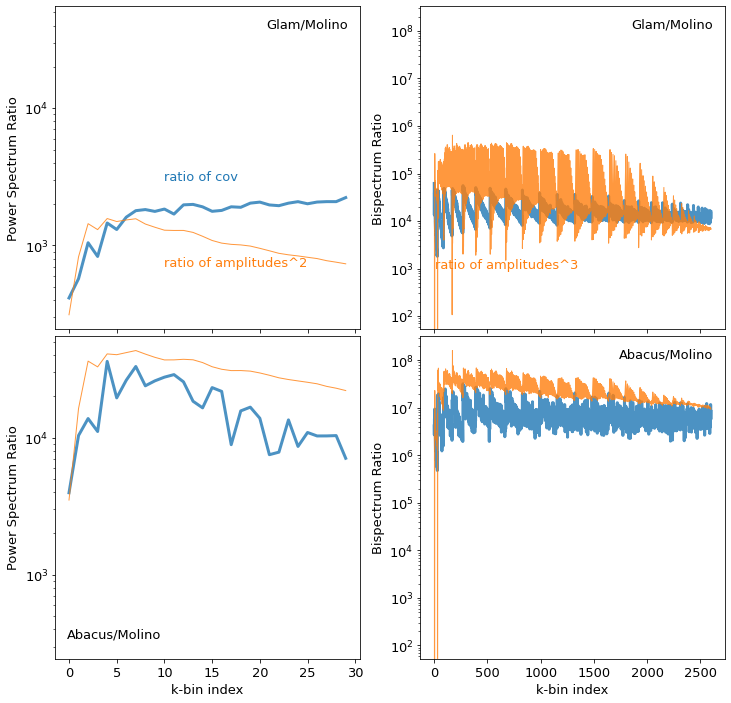

In [7]:
plot_ratios()

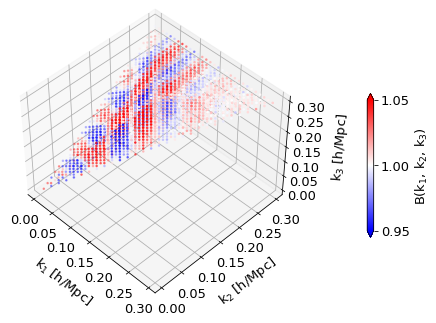

In [7]:
plot_glambk()

In [ ]:
# compare the ratio of covariance (diagonal) to the ratio of amplitudes
# Abacus variance is more sensitive to # of realizations rather than the amplitude